# Project-level bbox and tindex

In [1]:
ICESAT2_BOREAL_REPO_PATH = '/projects/Developer/icesat2_boreal' #'/projects/icesat2_boreal' # /projects/Developer/icesat2_boreal/lib
ICESAT2_BOREAL_LIB_PATH = ICESAT2_BOREAL_REPO_PATH + '/lib'
!pip install -U -r $ICESAT2_BOREAL_REPO_PATH/dps/requirements_main.txt

  Using cached s3fs-0.3.4-py3-none-any.whl (18 kB)
  Attempting uninstall: s3fs
    Found existing installation: s3fs 2023.1.0
    Uninstalling s3fs-2023.1.0:
      Successfully uninstalled s3fs-2023.1.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
from shapely.geometry import box
import geopandas as gpd
from geopandas import GeoDataFrame
import pandas as pd
import contextily as ctx
import os
import sys
sys.path.append('/projects/Developer/icesat2_boreal/lib')
import maplib_folium
import ExtractUtils

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
# Get boreal domain from wwf 
boreal_gdf = gpd.read_file('/projects/my-public-bucket/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson')

# Define a basic project bbox for a min near 50N

In [4]:
boreal_tiles = gpd.read_file('/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg')
bbox_project = boreal_tiles.to_crs(4326).total_bounds
bbox_project[1] = 51.6
bbox_project

array([-179.8325521 ,   51.6       ,  178.39934685,   78.53132756])

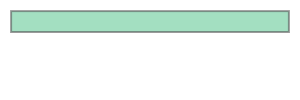

In [5]:
geom=box(*bbox_project)
geom

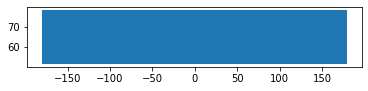

In [12]:
boreal_tiles.to_crs(4326).total_bounds

bbox_fn = '/projects/shared-buckets/nathanmthomas/project_bbox.gpkg'

gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[geom])
gdf['extent'] = 'boreal biomass domain'
gdf.plot()
gdf.to_file(bbox_fn, driver='GPKG')

# Select tiles for domain: BBOX min 50N

In [6]:
tindex_master_json_fn = '/projects/shared-buckets/nathanmthomas/DPS_tile_lists/AGB/c2020/map_boreal_2022_rh_noground_v4/AGB_tindex_master.json'
tindex_master_json_SUBSET_fn = os.path.splitext(tindex_master_json_fn)[0] + '_min50N.json'
tindex_master_mosaic_json_SUBSET_fn = os.path.splitext(tindex_master_json_fn)[0] + '_mosaic_min50N.json'

In [7]:
tindex_master_json_SUBSET_fn

'/projects/shared-buckets/nathanmthomas/DPS_tile_lists/AGB/c2020/map_boreal_2022_rh_noground_v4/AGB_tindex_master_min50N.json'

In [8]:
AGB_c2020_noground_tindex   = gpd.read_file(tindex_master_json_fn)

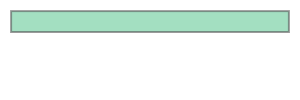

In [13]:
SUB_DOMAIN_selection_geometry = gdf.iloc[0].geometry # this is the same as 'geom'
SUB_DOMAIN_selection_geometry

In [15]:
#selector = AGB_c2020_noground_tindex.intersects(SUB_DOMAIN_selection_geometry)

In [16]:
print("Subset by SUB_DOMAIN...")
selector = AGB_c2020_noground_tindex.intersects(SUB_DOMAIN_selection_geometry)
AGB_c2020_noground_tindex_min50N = AGB_c2020_noground_tindex[selector]
AGB_c2020_noground_tindex_min50N.to_file(tindex_master_json_SUBSET_fn, driver='GeoJSON')

Subset by SUB_DOMAIN...


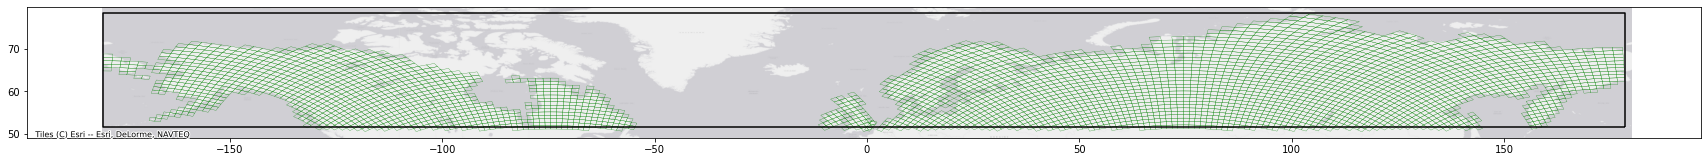

In [17]:
ax1 = AGB_c2020_noground_tindex_min50N.plot(facecolor='None', linewidth=0.25, ec='green', figsize=(30,10))
ax1 = gdf.boundary.plot(color='black', ax=ax1)
ax1 = ctx.add_basemap(ax1, crs=4326, 
            #source = ctx.providers.Esri.WorldShadedRelief
            source = ctx.providers.Esri.WorldGrayCanvas
            #source = ctx.providers.Esri.NatGeoWorldMap
            #source = ctx.providers.Esri.WorldImagery
        )

In [18]:
AGB_c2020_noground_tindex_min50N.total_bounds

array([-179.81819396,   50.47596222,  178.39934685,   78.53132756])

# Write Mosaic Json for min 50N tindex

In [27]:

def build_mosaic_json(input_tindex_gdf, input_json_fn, out_masic_json_fn):

    from cogeo_mosaic.mosaic import MosaicJSON
    from cogeo_mosaic.backends import MosaicBackend
    from typing import Dict


    def get_accessor(feature: Dict):
        """Return specific feature identifier."""
        return feature["properties"]["s3_path"]

    # Step 1 get the gdf of the tiles matches to the tindex master csv (from build_tindex_master.py on the dps_output)
    #tile_index_matches_gdf = get_tile_matches_gdf(tindex_master_fn, boreal_tile_index_path = boreal_tile_index_path, BAD_TILE_LIST = BAD_TILE_LIST, cols_list = cols_list)

    # Step 2 get the tiles json rfom the gdf of matched tiles
    tile_matches_geojson = ExtractUtils.build_tiles_json(input_tindex_gdf, input_json_fn, SHOW_MAP=True)

    print(f"Building {out_masic_json_fn}")
    mosaicdata = MosaicJSON.from_features(tile_matches_geojson.get('features'), minzoom=6, maxzoom=18, accessor=get_accessor)

    with MosaicBackend(out_masic_json_fn, mosaic_def=mosaicdata) as mosaic:
        mosaic.write(overwrite=True)

Building /projects/shared-buckets/nathanmthomas/DPS_tile_lists/AGB/c2020/map_boreal_2022_rh_noground_v4/AGB_tindex_master_mosaic_min50N.json


/projects/.local/lib/python3.7/site-packages/mercantile/__init__.py:79: FutureWarning: Mercantile 2.0 will require tile x and y to be within the range (0, 2 ** zoom)
  FutureWarning,


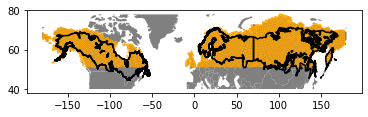

In [31]:
build_mosaic_json(AGB_c2020_noground_tindex_min50N, tindex_master_json_SUBSET_fn, tindex_master_mosaic_json_SUBSET_fn)

# Select tiles for domain: BOREAL

In [19]:
tindex_master_json_SUBSETBOREAL_fn = os.path.splitext(tindex_master_json_fn)[0] + '_boreal.json'
tindex_master_mosaic_json_SUBSETBOREAL_fn = os.path.splitext(tindex_master_json_fn)[0] + '_mosaic_boreal.json'

### Subset covariate tiles by broad domain (boreal)
* Build the spatial selector with 'intersects'
* do the subset accord to region (where region is identified with the spatial selector)

In [20]:
tile_group_region_string = 'wwf_boreal'

boreal_gdf['dissolve_field'] = 'for intersect'

boreal_geometry = boreal_gdf.dissolve(by='dissolve_field').iloc[0].geometry

# Do a dissolve so that there is only 1 polygon to intersect; .iloc[0]
selector_boreal = AGB_c2020_noground_tindex.to_crs(4326).intersects(boreal_geometry)
AGB_c2020_noground_tindex_BOREAL = AGB_c2020_noground_tindex.to_crs(4326)[selector_boreal]

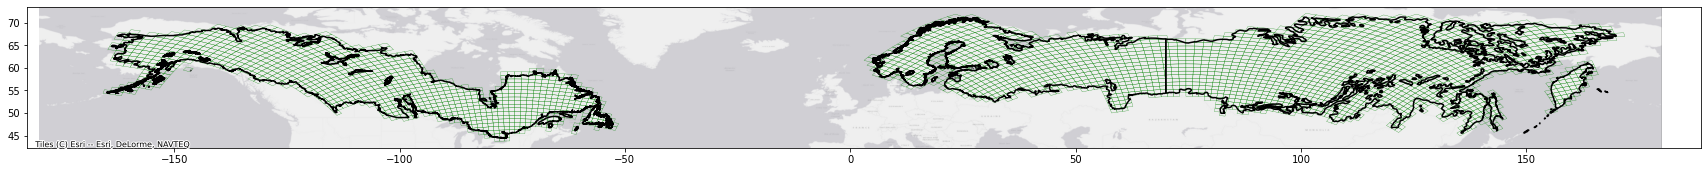

In [21]:
ax2 = AGB_c2020_noground_tindex_BOREAL.boundary.plot(linewidth=0.25, color='green', figsize=(30,10))
ax2 = boreal_gdf.boundary.plot(color='black', ax=ax2)
ax2 = ctx.add_basemap(ax2, crs=4326, 
            #source = ctx.providers.Esri.WorldShadedRelief
            source = ctx.providers.Esri.WorldGrayCanvas
            #source = ctx.providers.Esri.NatGeoWorldMap
            #source = ctx.providers.Esri.WorldImagery
        )

Building /projects/shared-buckets/nathanmthomas/DPS_tile_lists/AGB/c2020/map_boreal_2022_rh_noground_v4/AGB_tindex_master_mosaic_boreal.json


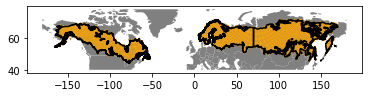

In [34]:
AGB_c2020_noground_tindex_BOREAL.to_file(tindex_master_json_SUBSETBOREAL_fn, driver='GeoJSON')
build_mosaic_json(AGB_c2020_noground_tindex_BOREAL, tindex_master_json_SUBSETBOREAL_fn, tindex_master_mosaic_json_SUBSETBOREAL_fn)

# For DAAC upload: build list of union both domains 

In [22]:
AGB_c2020_noground_tindex_min50N = gpd.read_file(tindex_master_json_SUBSET_fn, driver='GeoJSON')
AGB_c2020_noground_tindex_BOREAL = gpd.read_file(tindex_master_json_SUBSETBOREAL_fn, driver='GeoJSON')

### Do union

In [68]:
AGB_c2020_noground_tindex_DAAC = gpd.overlay(AGB_c2020_noground_tindex_BOREAL, AGB_c2020_noground_tindex_min50N, how='union').fillna(0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `keep_geom_type=True` in overlay resulted in 20870 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  """Entry point for launching an IPython kernel.


In [72]:
AGB_c2020_noground_tindex_DAAC.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3891 entries, 0 to 3890
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   tile_num_1      3891 non-null   float64 
 1   tile_version_1  3891 non-null   object  
 2   tile_group_1    3891 non-null   object  
 3   map_version_1   3891 non-null   int64   
 4   s3_path_1       3891 non-null   object  
 5   local_path_1    3891 non-null   object  
 6   tile_num_2      3891 non-null   float64 
 7   tile_version_2  3891 non-null   object  
 8   tile_group_2    3891 non-null   object  
 9   map_version_2   3891 non-null   int64   
 10  s3_path_2       3891 non-null   object  
 11  local_path_2    3891 non-null   object  
 12  geometry        3891 non-null   geometry
dtypes: float64(2), geometry(1), int64(2), object(8)
memory usage: 395.3+ KB


## Clean up DAAC tiles GDF for export to DAAC

In [73]:
AGB_c2020_noground_tindex_DAAC["tile_num"] = AGB_c2020_noground_tindex_DAAC["tile_num_1"].astype(int) + AGB_c2020_noground_tindex_DAAC["tile_num_2"].astype(int) 

In [78]:
AGB_c2020_noground_tindex_DAAC.s3_path_1.to_list()[0]

's3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_quick_v2_ubuntu/map_boreal_2022_rh_noground_v4/2023/02/15/05/42/01/342476/boreal_agb_202302151676439579_1326.tif'

# Export a boreal tiles DAAC subset 

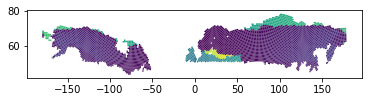

In [77]:
AGB_c2020_noground_tindex_DAAC[['tile_num', 'geometry']].plot(column='tile_num')
AGB_c2020_noground_tindex_DAAC[['tile_num', 'geometry']].to_file('/projects/shared-buckets/nathanmthomas/boreal_tiles_v003_DAAC.gpkg', driver='GPKG')

#### Clean and make final list

In [34]:
tmp_list = AGB_c2020_noground_tindex_DAAC.local_path_1.to_list() +  AGB_c2020_noground_tindex_DAAC.local_path_2.to_list()
len(tmp_list)

# Remove None and duplicates
boreal_agb_files = list(set([os.path.basename(x) for x in tmp_list if x is not None]))
len(boreal_agb_files)

3891

In [35]:
boreal_agb_files[0:5]

['boreal_agb_202302061675663994_36399.tif',
 'boreal_agb_202302061675659738_1552.tif',
 'boreal_agb_202302061675666219_3462.tif',
 'boreal_agb_202302061675657956_2282.tif',
 'boreal_agb_202302061675654569_1378.tif']

In [37]:
with open("/projects/my-public-bucket/boreal_agb_tiles_DAAC.txt", 'w') as file:
        for row in boreal_agb_files:
            s = "".join(map(str, row))
            file.write(s+'\n')

# -----------TMP stuff below

In [59]:

# https://databasin.org/datasets/1f624a31ab224835a78ad4bf11103419/
perma = gpd.read_file('/projects/shared-buckets/montesano/databank/permaice_extent.gpkg')
perma['NUM_CODE'] = pd.to_numeric(perma['NUM_CODE'])

In [71]:

permprob_ds = rasterio.open(permprob_fn)
permprob_ds.crs

CRS.from_epsg(3995)

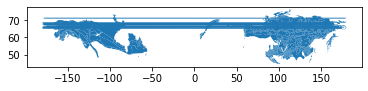

In [53]:

#z = gdf = clipGDF_keepgeomtyp_line(perma, boreal_gdf.to_crs(perma))

# Do a dissolve so that there is only 1 polygon to intersect; .iloc[0]
selector_boreal_perma = perma.to_crs(4326).intersects(boreal_geometry)
perma_BOREAL = perma.to_crs(4326)[selector_boreal_perma]
perma_BOREAL.plot()

# Rasterize the permafrost classes

In [72]:
# https://gis.stackexchange.com/questions/151339/rasterize-a-shapefile-with-geopandas-or-fiona-python

import geopandas as gpd
import rasterio
from rasterio import features


permprob_fn = '/projects/shared-buckets/montesano/databank/UiO_PEX_PERPROB_3.0_20171201_2000_2016.tif'
out_fn = '/projects/shared-buckets/montesano/databank/permaice_extent_NUM_CODE.tif'

permprob_ds = rasterio.open(permprob_fn)

# copy and update the metadata from the input raster for the output

meta = permprob_ds.meta.copy()
meta.update(compress='lzw')

# Now burn the features into the raster and write it out

with rasterio.open(out_fn, 'w+', **meta) as out:
    out_arr = out.read(1)

    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(perma.to_crs(permprob_ds.crs).geometry, perma.NUM_CODE + 100))

    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
    out.write_band(1, burned)

None


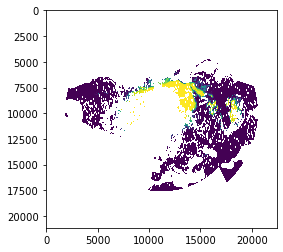

In [67]:
from rasterio.plot import show_hist, show
src = rasterio.open(permprob_fn)
print(src.profile['nodata'])
arr = src.read(1)
#arr = np.ma.masked_where((arr <0) , arr)
show(arr)

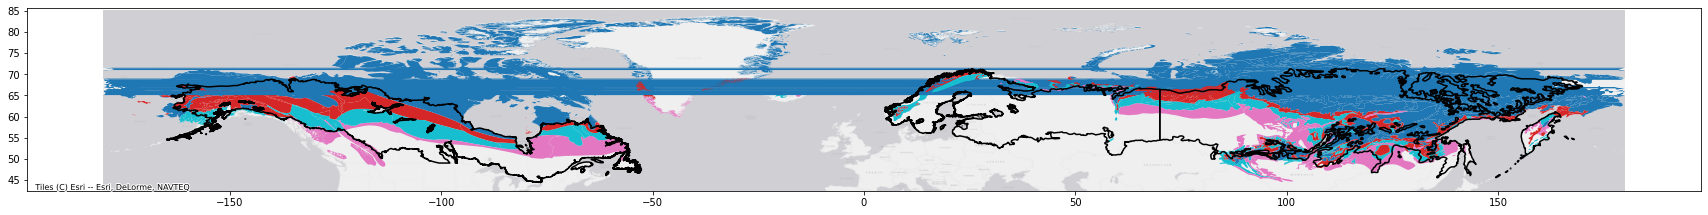

In [34]:
ax3 = perma.to_crs(4326).cx[-179:179, 50:90].plot(column='EXTENT', figsize=(30,10))
ax3 = boreal_gdf.boundary.plot(color='black', ax=ax3)
ax3 = ctx.add_basemap(ax3, crs=4326, 
            source = ctx.providers.Esri.WorldGrayCanvas
        )

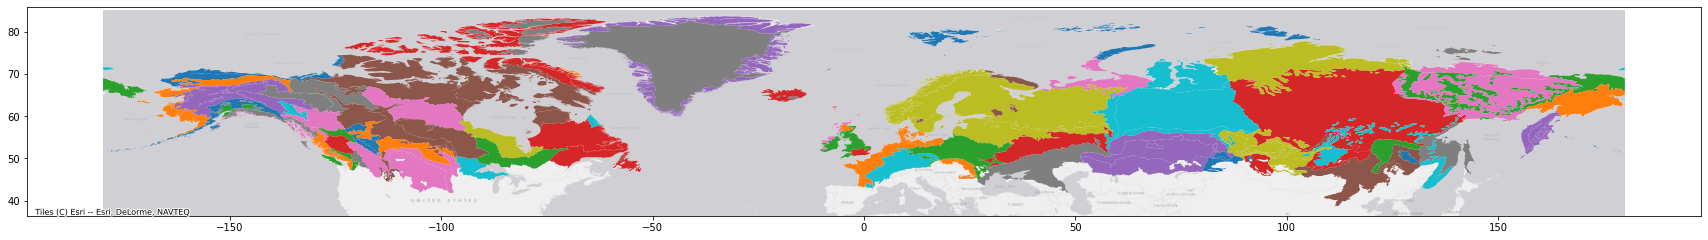

In [14]:
wwf_eco = gpd.read_file('/projects/shared-buckets/montesano/databank/wwf_terr_ecos.gpkg').to_crs(4326).cx[-179:179, 50:90]
ax3 = wwf_eco.plot(column='ECO_NAME', figsize=(30,10))
ax3 = ctx.add_basemap(ax3, crs=4326, 
            source = ctx.providers.Esri.WorldGrayCanvas
        )

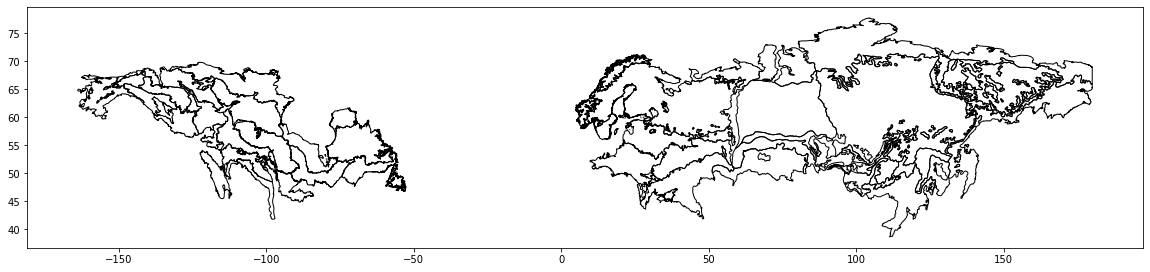

In [23]:
#tmp = gpd.sjoin(wwf_eco, boreal_gdf, how='left', op='contains')

# Do a dissolve so that there is only 1 polygon to intersect; .iloc[0]
selector_boreal_wwf = wwf_eco.to_crs(4326).intersects(boreal_geometry)
wwf_eco_BOREAL = wwf_eco.to_crs(4326)[selector_boreal_wwf]

wwf_eco_BOREAL[wwf_eco_BOREAL.area_km2 > 200000 ].plot(facecolor='None', ec='k', figsize=(20,10))

In [21]:
tmp[tmp.area_km2 > 200000 ].info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1729 entries, 439 to 7608
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   OBJECTID_left     1729 non-null   int64   
 1   AREA              1729 non-null   float64 
 2   PERIMETER         1729 non-null   float64 
 3   ECO_NAME          1729 non-null   object  
 4   REALM_left        1729 non-null   object  
 5   BIOME             1729 non-null   float64 
 6   ECO_NUM           1729 non-null   float64 
 7   ECO_ID            1729 non-null   float64 
 8   ECO_SYM           1729 non-null   float64 
 9   GBL_STAT          1729 non-null   float64 
 10  G200_REGIO        376 non-null    object  
 11  G200_NUM          1729 non-null   float64 
 12  G200_BIOME        1729 non-null   float64 
 13  G200_STAT         1729 non-null   float64 
 14  Shape_Leng_left   1729 non-null   float64 
 15  Shape_Area_left   1729 non-null   float64 
 16  area_km2      